--- Loading Data from /content/hplc_data_table.xlsx ---
  Loaded 195 total valid data points from 6 experiments.
  Initial conditions (y0 - fraction remaining) determined per batch. Average y0 = 0.9787 will be used for plotting model lines.
  Using INITIAL_PURITY = 100.0 for calculating fractional remaining 'y'.

--- Performing Truly Global Fit for Degradation (Training Data <= 97 days) ---
Fitting single global Ea, n, m, and log(A) using 180 data points.
Weighting is disabled.
Using Initial Guesses (p0): Ea=80.0, n=1.00, m=0.00, logA=20.00

--- Fit Results (Degradation Model - Trained on <= 97 days) ---
Global Ea = 86.87 +/- 1.70 kJ/mol
Global n  = 3.721 +/- 1.233
Global m  = 0.307 +/- 0.106
Global log(A) = 28.173 +/- 0.600  => A ~ 1.72e+12 +/- 1.03e+12

--- Goodness-of-Fit (on Training Data) ---
  Overall R-squared (R²) on Training Data = 0.9928
  Overall RMSE on Training Data = 0.3465 (% Purity)

--- Comparison: Actual vs. Predicted Values (All Data) ---
       Experiment  Temperatu

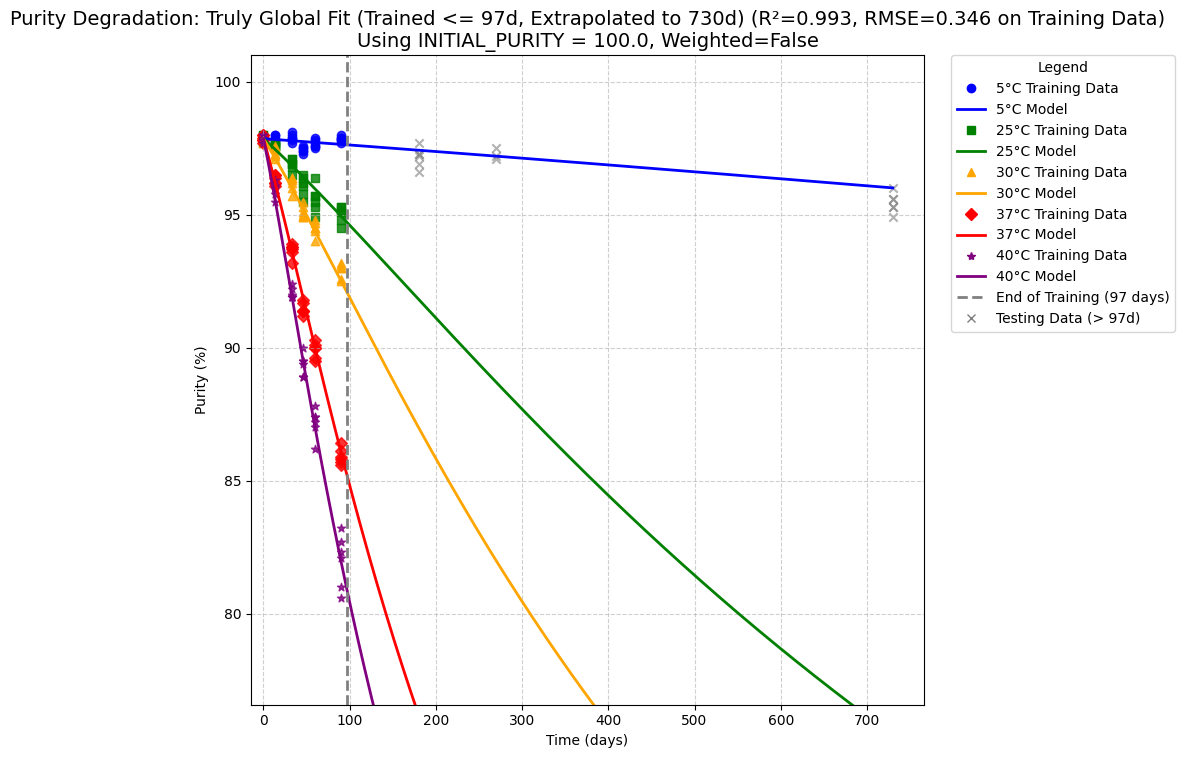


--- Script Finished ---


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import warnings
import math

# --- Configuration ---
# !!! IMPORTANT: Adjust path if your file is located elsewhere !!!
EXCEL_FILE_PATH = '/content/hplc_data_table.xlsx' # <--- Make sure this file exists!

# --- Degradation Specific Configuration ---
PURITY_COLUMN_NAME = 'Purity' # <--- Column name for assay/purity data
INITIAL_PURITY = 100.0 # <--- Assumed starting purity/assay (e.g., 100.0 for %) Adjust if needed.

# --- Training and Prediction Configuration ---
TRAINING_CUTOFF_DAYS = 97 # Use data up to this day for fitting
PREDICTION_DAYS = 730 # Extrapolate up to this day in the plot (approx 2 years)

# --- Weighting Configuration ---
apply_weighting = False # Set to False to disable weighting (User preference)
weight_factor_5C = 5 # How much more weight for 5C data (if apply_weighting is True)

# --- Constants ---
R = 8.314e-3  # Gas constant in kJ/mol/K

# --- 1. Data Loading and Preparation ---
print(f"--- Loading Data from {EXCEL_FILE_PATH} ---")
try:
    df = pd.read_excel(EXCEL_FILE_PATH)
    # Basic validation for degradation data
    required_cols = ['Experiment', 'Temperature_C', 'Time_days', PURITY_COLUMN_NAME]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Excel file must contain columns: {required_cols}")
    # Drop rows with missing values in essential columns
    df.dropna(subset=required_cols, inplace=True)
    if df.empty:
        raise ValueError("No valid data remaining after dropping rows with missing values.")
    print(f"  Loaded {len(df)} total valid data points from {df['Experiment'].nunique()} experiments.")
except FileNotFoundError:
    print(f"ERROR: Excel file not found at '{EXCEL_FILE_PATH}'. Please ensure the file exists.")
    exit()
except ValueError as e:
    print(f"ERROR: {e}")
    exit()
except Exception as e:
    print(f"ERROR loading or validating Excel file: {e}")
    exit()

# Convert Celsius to Kelvin
df['Temperature_K'] = df['Temperature_C'] + 273.15

# Define fractional variable 'y' as fraction REMAINING
df['y'] = df[PURITY_COLUMN_NAME] / INITIAL_PURITY
# Ensure y doesn't go below 0 or significantly above 1 (due to noise near initial value)
df['y'] = df['y'].clip(lower=0.0, upper=1.0 + 1e-6) # Allow slightly above 1 for initial noise

# Get unique batch names (Experiments)
unique_batches = df['Experiment'].unique()

# Determine initial condition y0 (fraction remaining at t=0) for each batch
y0_per_batch = {}
y0_values_list = [] # To calculate average y0
for batch_name in unique_batches:
    batch_data = df[df['Experiment'] == batch_name]
    t0_data = batch_data[np.isclose(batch_data['Time_days'], 0)]
    if t0_data.empty:
        # If no t=0, use the *maximum* observed y in that batch as a proxy for y0 (closest to initial)
        max_y_in_batch = batch_data['y'].max() if not batch_data.empty else 1.0
        warnings.warn(f"Warning: No t=0 data found for batch '{batch_name}'. Using maximum observed y ({max_y_in_batch:.4f}) as y0.")
        # Ensure y0 is slightly below 1 if max_y is 1, to avoid issues in ODE if m > 0
        current_y0 = min(max_y_in_batch, 1.0 - 1e-9)
    else:
        # Use the mean y at t=0
        y0_val = t0_data['y'].mean()
        # Ensure y0 is not significantly greater than 1 and slightly below 1
        current_y0 = np.maximum(1e-9, np.minimum(y0_val, 1.0 - 1e-9)) # Clip y0 just below 1 if needed

    y0_per_batch[batch_name] = current_y0
    y0_values_list.append(current_y0)

# Calculate the average y0 across all batches (should be close to 1.0)
average_y0 = np.mean(y0_values_list) if y0_values_list else (1.0 - 1e-9) # Default near 1 if no y0 found
print(f"  Initial conditions (y0 - fraction remaining) determined per batch. Average y0 = {average_y0:.4f} will be used for plotting model lines.")
print(f"  Using INITIAL_PURITY = {INITIAL_PURITY} for calculating fractional remaining 'y'.")


# --- 2. Define the Differential Equation Model for Degradation ---
def model_ode(t, y, k, n, m):
    """
    Differential equation for degradation: dy/dt = -k * y^n * (1-y)^m
    where y is the fraction remaining. Rate is negative.
    Includes clamping to avoid numerical issues near y=0 or y=1.
    """
    eps = 1e-9
    # Clamp y slightly away from 0 and 1 before applying exponents
    y_val = y[0] if isinstance(y, (list, np.ndarray)) else y # Get scalar value
    y_clamped = np.maximum(eps, np.minimum(y_val, 1.0 - eps))

    # Ensure bases for powers are non-negative
    term1_base = y_clamped       # Fraction remaining (y)
    term2_base = 1.0 - y_clamped # Fraction degraded (1-y)

    # Calculate terms safely
    # y^n term: Represents dependence on remaining concentration
    term1 = np.real(term1_base**n) if term1_base >= 0 else 0
    # (1-y)^m term: Represents inhibition by degraded product or complex mechanism
    term2 = np.real(term2_base**m) if term2_base >= 0 else 0

    # Rate is negative for degradation
    dydt = -k * term1 * term2
    # Ensure rate is non-positive
    return min(0, dydt)

# --- 3. Define the Truly Global Fitting Function ---
def truly_global_model_simulate(df_input_indices, Ea, n, m, logA):
    """
    Simulates Purity decrease using a single set of kinetic parameters (Ea, n, m, logA)
    for the data points specified by df_input_indices, using batch info only for y0.
    """
    global df # Access the full dataframe to lookup row details by index
    global y0_per_batch # Still needed here to use correct starting point for fitting each data point

    df_subset = df.loc[df_input_indices]
    y_predicted_all = np.zeros(len(df_subset), dtype=float)
    A = np.exp(logA)
    eps = 1e-9

    for i, index in enumerate(df_input_indices):
        row = df_subset.loc[index]
        batch_name = row['Experiment']
        temp_K = row['Temperature_K']
        time_point = row['Time_days']
        y0 = y0_per_batch[batch_name] # Use the specific y0 for this batch during fitting
        k = A * np.exp(-Ea / (R * temp_K))

        if not np.isfinite(k) or k <= 0:
            return np.full(len(df_subset), -1e10) # Return large negative penalty

        if np.isclose(time_point, 0):
            y_pred = y0
        else:
            try:
                sol = solve_ivp(
                    model_ode, t_span=[0, time_point], y0=[y0], t_eval=[time_point],
                    args=(k, n, m), method='RK45', rtol=1e-6, atol=1e-8
                )
                if sol.status != 0:
                     # Check if solver failed because y became too small (numerical issue)
                     if sol.y is not None and len(sol.y[0]) > 0 and sol.y[0][-1] < eps:
                         y_pred = 0.0 # Set prediction to 0 if it likely hit the lower bound
                     else:
                        # warnings.warn(f"ODE solver failed for {batch_name}, T={temp_K-273.15:.1f}°C, t={time_point}d. Status: {sol.status}")
                        return np.full(len(df_subset), -1e10) # Return large negative penalty
                else:
                    y_pred = sol.y[0, -1]
            except Exception as ode_err:
                # warnings.warn(f"ODE solver error for {batch_name}, T={temp_K-273.15:.1f}°C, t={time_point}d: {ode_err}")
                return np.full(len(df_subset), -1e10) # Return large negative penalty

        # Clamp prediction between 0 and the starting value y0
        y_predicted_all[i] = np.maximum(0.0, np.minimum(y_pred, y0 + eps)) # Ensure y >= 0 and y <= y0

    if not np.all(np.isfinite(y_predicted_all)):
        warnings.warn("Non-finite values detected in simulation output.")
        # Check where the non-finite values occurred
        # print(f"Indices with non-finite values: {df_input_indices[~np.isfinite(y_predicted_all)]}")
        # print(f"Predicted values: {y_predicted_all[~np.isfinite(y_predicted_all)]}")
        return np.full(len(df_subset), -1e10) # Return large negative penalty

    return y_predicted_all

# --- 4. Perform Truly Global Fit (Using Training Data <= CUTOFF_DAYS) ---
print(f"\n--- Performing Truly Global Fit for Degradation (Training Data <= {TRAINING_CUTOFF_DAYS} days) ---")

# Select the training data subset
df_train = df[df['Time_days'] <= TRAINING_CUTOFF_DAYS].copy()
print(f"Fitting single global Ea, n, m, and log(A) using {len(df_train)} data points.")
if len(df_train) < 4:
     print(f"ERROR: Insufficient training data points ({len(df_train)}) for fitting. Need at least 4.")
     exit()

if apply_weighting:
    print(f"Applying weighting: 5°C data points have {weight_factor_5C}x more weight.")
else:
    print("Weighting is disabled.")

# Prepare data for curve_fit using the training subset
x_data_fit = df_train.index # Pass indices *from the original df* for the training subset
y_data_fit = df_train['y'].values # Target variable (fraction remaining) from the training subset

# --- Define Weights (sigma) for the training subset ---
sigma_weights = None
if apply_weighting:
    sigma_weights = np.ones_like(y_data_fit)
    five_C_indices_in_train = df_train[df_train['Temperature_C'] == 5].index
    mask = np.isin(x_data_fit, five_C_indices_in_train)
    sigma_weights[mask] = 1.0 / weight_factor_5C

# --- Initial Guesses (p0) ---
# May need adjustment based on degradation rate
initial_Ea_guess = 80
initial_n_guess = 1.0 # Often first-order decay (n=1) is a good start for degradation
initial_m_guess = 0.0 # Often m=0 is a good start (no product inhibition)
initial_logA_guess = 20
p0 = [initial_Ea_guess, initial_n_guess, initial_m_guess, initial_logA_guess]
print(f"Using Initial Guesses (p0): Ea={p0[0]:.1f}, n={p0[1]:.2f}, m={p0[2]:.2f}, logA={p0[3]:.2f}")

# --- Bounds for parameters ---
bounds_low = [10, 0, 0, -np.inf] # Ea>10, n>=0, m>=0
bounds_high = [300, 5, 5, np.inf] # Upper bounds for n, m
bounds = (bounds_low, bounds_high)

fit_successful = False
popt = None # Initialize popt
Ea_fit, n_fit, m_fit, logA_fit = (np.nan,) * 4 # Initialize fit parameters
r_squared, rmse = np.nan, np.nan # Initialize metrics

try:
    with warnings.catch_warnings():
        # warnings.simplefilter("ignore", category=RuntimeWarning)
        # warnings.simplefilter("ignore", category=OptimizeWarning)
        popt, pcov = curve_fit(
            truly_global_model_simulate,
            xdata=x_data_fit,
            ydata=y_data_fit,
            p0=p0,
            sigma=sigma_weights,
            absolute_sigma=False,
            bounds=bounds,
            method='trf', # 'lm' might also work if bounds aren't strictly needed
            max_nfev=5000,
            ftol=1e-6, xtol=1e-6, gtol=1e-6
        )

    if pcov is None or not np.all(np.isfinite(pcov)):
         warnings.warn("Covariance matrix calculation failed or contains non-finite values. Parameter errors cannot be estimated reliably.")
         perr = np.full(len(popt), np.nan)
    else:
         perr = np.sqrt(np.diag(pcov))

    Ea_fit = popt[0]
    n_fit = popt[1]
    m_fit = popt[2]
    logA_fit = popt[3]
    A_fit = np.exp(logA_fit)
    Ea_err = perr[0]
    n_err = perr[1]
    m_err = perr[2]
    logA_err = perr[3]
    A_err_val = A_fit * logA_err if not np.isnan(logA_err) else np.nan

    print("\n--- Fit Results (Degradation Model - Trained on <= 97 days) ---")
    print(f"Global Ea = {Ea_fit:.2f} +/- {Ea_err:.2f} kJ/mol")
    print(f"Global n  = {n_fit:.3f} +/- {n_err:.3f}") # Order w.r.t. remaining Purity
    print(f"Global m  = {m_fit:.3f} +/- {m_err:.3f}") # Order w.r.t. (1 - Purity/Initial)
    print(f"Global log(A) = {logA_fit:.3f} +/- {logA_err:.3f}  => A ~ {A_fit:.2e} +/- {A_err_val:.2e}")

    fit_successful = True

    # --- 5. Calculate Goodness-of-Fit Metrics (on Training Data) ---
    print("\n--- Goodness-of-Fit (on Training Data) ---")
    # Simulate using the final fitted parameters ONLY for the training data indices
    y_predicted_train = truly_global_model_simulate(x_data_fit, Ea_fit, n_fit, m_fit, logA_fit)

    if np.any(y_predicted_train < -1e9): # Check for large negative penalty
         print("  Error: Training data prediction contains penalty values. Fit metrics are unreliable.")
         r_squared = np.nan
         rmse = np.nan
    else:
        # Calculate metrics based on unweighted residuals using original Purity units for training data
        purity_predicted_train = y_predicted_train * INITIAL_PURITY
        purity_actual_train = df_train[PURITY_COLUMN_NAME].values # Actual Purity from the training subset
        residuals_train = purity_actual_train - purity_predicted_train
        ss_res_train = np.sum(residuals_train**2)
        ss_tot_train = np.sum((purity_actual_train - np.mean(purity_actual_train))**2)

        if ss_tot_train == 0:
            r_squared = 1.0 if np.isclose(ss_res_train, 0) else 0.0
        else:
            r_squared = 1.0 - (ss_res_train / ss_tot_train)

        mse_train = np.mean(residuals_train**2)
        rmse = math.sqrt(mse_train)
        print(f"  Overall R-squared (R²) on Training Data = {r_squared:.4f}")
        print(f"  Overall RMSE on Training Data = {rmse:.4f} (% {PURITY_COLUMN_NAME})") # Use correct unit

    # --- 5b. Generate Predictions for ALL Data and Create Comparison Table ---
    print("\n--- Comparison: Actual vs. Predicted Values (All Data) ---")
    # Simulate using the final fitted parameters for ALL data indices
    y_predicted_all = truly_global_model_simulate(df.index, Ea_fit, n_fit, m_fit, logA_fit)

    if np.any(y_predicted_all < -1e9): # Check for large negative penalty
        print("  Error: Prediction for all data contains penalty values. Comparison table cannot be generated.")
        df_comparison = None # Indicate failure
    else:
        # Create a comparison DataFrame
        df_comparison = df[['Experiment', 'Temperature_C', 'Time_days', PURITY_COLUMN_NAME]].copy()
        df_comparison['Predicted_Purity'] = y_predicted_all * INITIAL_PURITY
        # Calculate the difference (Actual - Predicted)
        df_comparison['Difference'] = df_comparison[PURITY_COLUMN_NAME] - df_comparison['Predicted_Purity']

        # Display the comparison table (first 20 rows for brevity)
        # Rename PURITY_COLUMN_NAME to 'Actual_Purity' for clarity in the table output
        df_comparison.rename(columns={PURITY_COLUMN_NAME: 'Actual_Purity'}, inplace=True)
        with pd.option_context('display.max_rows', 20,
                               'display.float_format', '{:.3f}'.format): # Format floats
             # Select columns to display in desired order
             print(df_comparison[['Experiment', 'Temperature_C', 'Time_days', 'Actual_Purity', 'Predicted_Purity', 'Difference']])

        # Optional: Save the full comparison table to a CSV file
        try:
            comparison_filename = 'purity_comparison_actual_vs_predicted.csv'
            # Save with the renamed column and desired order
            df_comparison[['Experiment', 'Temperature_C', 'Time_days', 'Actual_Purity', 'Predicted_Purity', 'Difference']].to_csv(
                comparison_filename, index=False, float_format='%.3f'
            )
            print(f"\nFull comparison table saved to '{comparison_filename}'")
        except Exception as e:
            print(f"\nError saving comparison table: {e}")


except RuntimeError as e:
    print(f"\nERROR: curve_fit failed to converge: {e}")
    print(f"=> ACTION: Try adjusting INITIAL_PURITY (line 18) and/or Initial Guesses (p0, lines 218-221). Check data <= {TRAINING_CUTOFF_DAYS} days.")
    fit_successful = False
    df_comparison = None # Ensure comparison df is None if fit fails
except Exception as e:
     print(f"\nERROR during fitting process: {e}")
     fit_successful = False
     df_comparison = None # Ensure comparison df is None if fit fails


# --- 6. Prediction and Plotting (Single Plot with Extrapolation) ---
print(f"\n--- Generating Plot for Degradation (Extrapolating to {PREDICTION_DAYS} days) ---")

fig, ax = plt.subplots(figsize=(12, 8)) # Single plot, slightly larger

temp_colors = {5: 'blue', 25: 'green', 30: 'orange', 37: 'red', 40: 'purple'}
temp_markers = {5: 'o', 25: 's', 30: '^', 37: 'D', 40: '*'}
testing_marker = 'x' # Marker for testing data
testing_color = 'grey' # Color for testing data

plot_handles = []
plot_labels = []

# Plot experimental data points, differentiating training and testing
print("  Plotting experimental data points (distinguishing training/testing)...")
for temp_C in sorted(df['Temperature_C'].unique()):
    temp_df = df[df['Temperature_C'] == temp_C]
    color = temp_colors.get(temp_C, 'black')
    marker = temp_markers.get(temp_C, 'x')

    # Split data for this temperature into training and testing
    train_points = temp_df[temp_df['Time_days'] <= TRAINING_CUTOFF_DAYS]
    test_points = temp_df[temp_df['Time_days'] > TRAINING_CUTOFF_DAYS]

    # Plot training points (colored)
    if not train_points.empty:
        ax.scatter(train_points['Time_days'], train_points[PURITY_COLUMN_NAME], # Plot actual Purity
                   color=color, marker=marker, alpha=0.8, label=f'_nolegend_')
        handle = plt.Line2D([0], [0], marker=marker, color=color, linestyle='None', label=f'{temp_C}°C Training Data')
        if handle.get_label() not in plot_labels:
             plot_handles.append(handle)
             plot_labels.append(handle.get_label())

    # Plot testing points (grey 'x')
    if not test_points.empty:
        ax.scatter(test_points['Time_days'], test_points[PURITY_COLUMN_NAME], # Plot actual Purity
                   color=testing_color, marker=testing_marker, alpha=0.6, label=f'_nolegend_')

# Add a single legend entry for testing data, if any testing data exists
if any(df['Time_days'] > TRAINING_CUTOFF_DAYS):
    handle_test = plt.Line2D([0], [0], marker=testing_marker, color=testing_color, linestyle='None',
                             label=f'Testing Data (> {TRAINING_CUTOFF_DAYS}d)')
    plot_handles.append(handle_test)
    plot_labels.append(handle_test.get_label())


# Plot ONE simulated curve per temperature using the global fit parameters if successful
if fit_successful:
    print(f"  Plotting single model extrapolation line per temperature up to {PREDICTION_DAYS} days...")
    plot_time_points = np.linspace(0, PREDICTION_DAYS, 300) # Time points for smooth curves
    A_val = np.exp(logA_fit)

    temps_in_data = sorted(df['Temperature_C'].unique())
    for temp_C in temps_in_data:
        temp_K = temp_C + 273.15
        color = temp_colors.get(temp_C, 'black')
        k_sim = A_val * np.exp(-Ea_fit / (R * temp_K))

        try:
            # Simulate using the AVERAGE y0 for the representative curve
            sol_plot = solve_ivp(
                model_ode, t_span=[0, plot_time_points[-1]], y0=[average_y0], # Use average_y0
                t_eval=plot_time_points, args=(k_sim, n_fit, m_fit),
                method='RK45', rtol=1e-6, atol=1e-8
            )
            if sol_plot.status == 0:
                purity_sim = sol_plot.y[0] * INITIAL_PURITY # Convert back to Purity scale
                line_handle, = ax.plot(sol_plot.t, purity_sim, color=color, linestyle='-',
                                       linewidth=2, label=f'{temp_C}°C Model') # Label for legend
                if line_handle.get_label() not in plot_labels:
                    plot_handles.append(line_handle)
                    plot_labels.append(line_handle.get_label())
            else:
                 print(f"Warning: ODE solver failed during plotting simulation for {temp_C}°C.")

        except Exception as plot_ode_err:
             print(f"Warning: ODE solver error during plotting simulation for {temp_C}°C: {plot_ode_err}")

# Add vertical line for training data cutoff
ax.axvline(x=TRAINING_CUTOFF_DAYS, color='grey', linestyle='--', linewidth=2,
           label=f'_nolegend_')
vline_handle = plt.Line2D([0], [0], color='grey', linestyle='--', linewidth=2)
plot_handles.append(vline_handle)
plot_labels.append(f'End of Training ({TRAINING_CUTOFF_DAYS} days)')


# Configure the plot
ax.set_xlabel("Time (days)")
ax.set_ylabel(f"{PURITY_COLUMN_NAME} (%)") # Update y-axis label
title_status = f"(R²={r_squared:.3f}, RMSE={rmse:.3f} on Training Data)" if fit_successful else "(Fit Failed)"
ax.set_title(f"{PURITY_COLUMN_NAME} Degradation: Truly Global Fit (Trained <= {TRAINING_CUTOFF_DAYS}d, Extrapolated to {PREDICTION_DAYS}d) {title_status}\nUsing INITIAL_PURITY = {INITIAL_PURITY}, Weighted={apply_weighting}", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
# Adjust y-limits for degradation (e.g., 90-101%)
min_purity_data = df[PURITY_COLUMN_NAME].min() if not df.empty else 0
ax.set_ylim(bottom=max(0, min_purity_data * 0.95)) # Slightly below min observed data, but not negative
ax.set_ylim(top=INITIAL_PURITY * 1.01) # Slightly above initial purity
ax.set_xlim(left=-PREDICTION_DAYS * 0.02)

# Create a combined legend
if plot_handles:
    try:
        def sort_key(label):
            if "End of Training" in label: return (998, 0)
            if "Testing Data" in label: return (999, 0)
            parts = label.split('°C')
            temp_str = ''.join(filter(str.isdigit, parts[0]))
            temp = int(temp_str) if temp_str else 997
            type_sort = 0 if 'Data' in label else 1
            return (temp, type_sort)

        unique_labels_handles = {label: handle for handle, label in zip(plot_handles, plot_labels)}
        sorted_labels = sorted(unique_labels_handles.keys(), key=sort_key)
        sorted_handles = [unique_labels_handles[lbl] for lbl in sorted_labels]

        ax.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0., title="Legend")
    except Exception as e:
        print(f"Could not create sorted legend: {e}")
        ax.legend(title="Legend")

fig.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()

print("\n--- Script Finished ---")
if not fit_successful:
    print("--- >>> Fitting Failed <<< ---")
    print(f"Recommendation: Adjust INITIAL_PURITY (line 18) and/or Initial Guesses (p0, lines 218-221). Check data quality <= {TRAINING_CUTOFF_DAYS} days.")

--- Loading Data from /content/stability_data.xlsx ---
  Loaded 168 total valid data points from 6 experiments.
  Initial conditions (y0 - fraction formed) determined per batch. Average y0 = 0.0453 will be used for plotting model lines.
  Using HMWP_MAX = 5.0 for calculating fractional formation 'y'.

--- Performing Truly Global Fit for HMWP Formation (Training Data <= 97 days) ---
Fitting single global Ea, n, m, and log(A) using 150 data points.
Weighting is disabled.
Using Initial Guesses (p0): Ea=80.0, n=0.00, m=1.00, logA=20.00

--- Fit Results (HMWP Formation Model - Trained on <= 97 days) ---
Global Ea = 61.56 +/- 3.04 kJ/mol
Global n  = 0.000 +/- 0.300
Global m  = 3.518 +/- 1.605
Global log(A) = 18.692 +/- 1.368  => A ~ 1.31e+08 +/- 1.80e+08

--- Goodness-of-Fit (on Training Data) ---
  Overall R-squared (R²) on Training Data = 0.9578
  Overall RMSE on Training Data = 0.0888 (% HMWP)

--- Comparison: Actual vs. Predicted Values (All Data) ---
       Experiment  Temperature_C  Ti

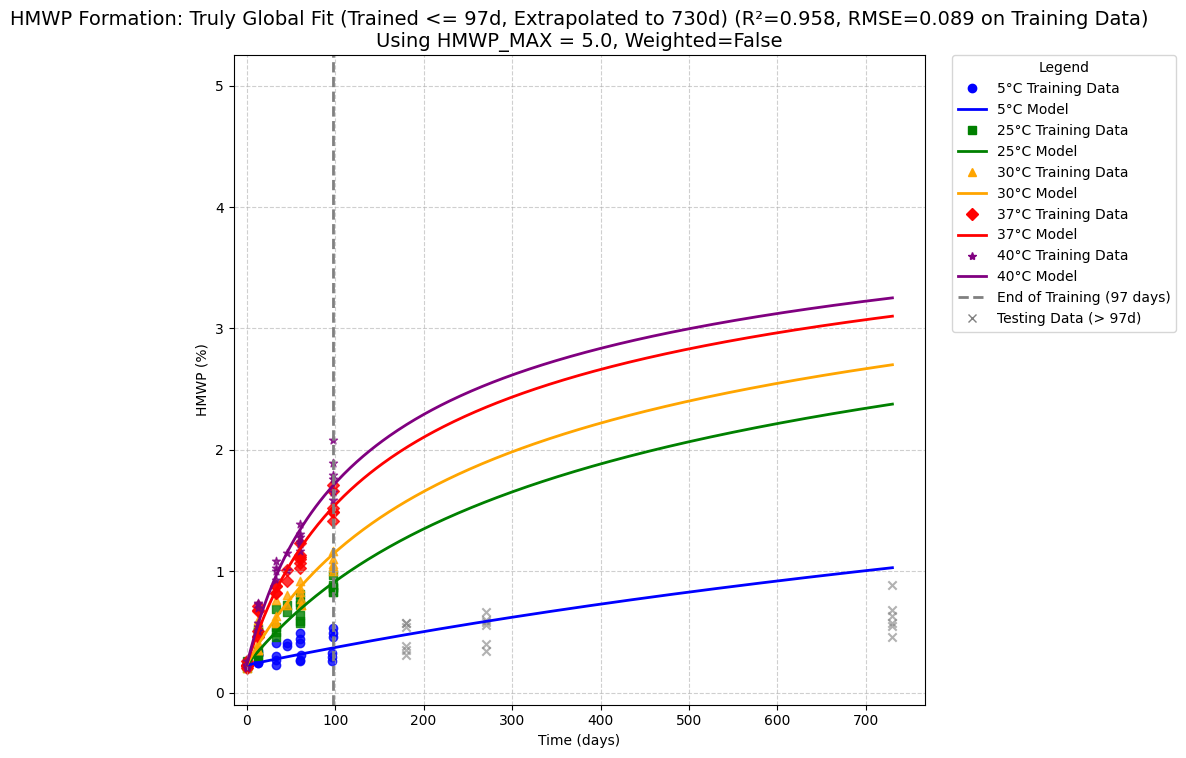


--- Script Finished ---


In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import warnings
import math

# --- Configuration ---
# !!! IMPORTANT: Adjust path if your file is located elsewhere !!!
EXCEL_FILE_PATH = '/content/stability_data.xlsx' # <--- Make sure this file exists!

# --- HMWP Specific Configuration ---
HMWP_COLUMN_NAME = 'HMWP' # <--- Column name for HMWP data
# !!! IMPORTANT: Adjust HMWP_MAX based on expected plateau !!!
HMWP_MAX = 5.0 # Assumed maximum HMWP (%), adjust based on data observation

# --- Training and Prediction Configuration ---
TRAINING_CUTOFF_DAYS = 97 # Use data up to this day for fitting
PREDICTION_DAYS = 730 # Extrapolate up to this day in the plot (approx 2 years)

# --- Weighting Configuration ---
apply_weighting = False # Set to False to disable weighting (User preference)
weight_factor_5C = 5 # How much more weight for 5C data (if apply_weighting is True)

# --- Constants ---
R = 8.314e-3  # Gas constant in kJ/mol/K

# --- 1. Data Loading and Preparation ---
print(f"--- Loading Data from {EXCEL_FILE_PATH} ---")
try:
    df = pd.read_excel(EXCEL_FILE_PATH)
    # Basic validation for HMWP data
    required_cols = ['Experiment', 'Temperature_C', 'Time_days', HMWP_COLUMN_NAME]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Excel file must contain columns: {required_cols}")
    # Drop rows with missing values in essential columns
    df.dropna(subset=required_cols, inplace=True)
    if df.empty:
        raise ValueError("No valid data remaining after dropping rows with missing values.")
    print(f"  Loaded {len(df)} total valid data points from {df['Experiment'].nunique()} experiments.")
except FileNotFoundError:
    print(f"ERROR: Excel file not found at '{EXCEL_FILE_PATH}'. Please ensure the file exists.")
    exit()
except ValueError as e:
    print(f"ERROR: {e}")
    exit()
except Exception as e:
    print(f"ERROR loading or validating Excel file: {e}")
    exit()

# Convert Celsius to Kelvin
df['Temperature_K'] = df['Temperature_C'] + 273.15

# Define fractional variable 'y' as fraction FORMED
df['y'] = df[HMWP_COLUMN_NAME] / HMWP_MAX
# Ensure y doesn't go significantly below 0 or above 1
df['y'] = df['y'].clip(lower=-1e-6, upper=1.0) # Allow slightly negative for noise near 0

# Get unique batch names (Experiments)
unique_batches = df['Experiment'].unique()

# Determine initial condition y0 (fraction formed at t=0) for each batch
y0_per_batch = {}
y0_values_list = [] # To calculate average y0
for batch_name in unique_batches:
    batch_data = df[df['Experiment'] == batch_name]
    t0_data = batch_data[np.isclose(batch_data['Time_days'], 0)]
    if t0_data.empty:
        # If no t=0, use the *minimum* observed y in that batch as a proxy for y0 (closest to initial)
        min_y_in_batch = batch_data['y'].min() if not batch_data.empty else 0.0
        warnings.warn(f"Warning: No t=0 data found for batch '{batch_name}'. Using minimum observed y ({min_y_in_batch:.4f}) as y0.")
        # Ensure y0 is slightly above 0 if min_y is 0, to avoid issues in ODE
        current_y0 = max(min_y_in_batch, 1e-9)
    else:
        # Use the mean y at t=0
        y0_val = t0_data['y'].mean()
        # Ensure y0 is not significantly less than 0 and slightly above 0
        current_y0 = np.maximum(1e-9, np.minimum(y0_val, 1.0 - 1e-9)) # Clip y0 just above 0 if needed

    y0_per_batch[batch_name] = current_y0
    y0_values_list.append(current_y0)

# Calculate the average y0 across all batches (should be close to 0.0)
average_y0 = np.mean(y0_values_list) if y0_values_list else 1e-9 # Default near 0 if no y0 found
print(f"  Initial conditions (y0 - fraction formed) determined per batch. Average y0 = {average_y0:.4f} will be used for plotting model lines.")
print(f"  Using HMWP_MAX = {HMWP_MAX} for calculating fractional formation 'y'.")


# --- 2. Define the Differential Equation Model for Formation ---
def model_ode(t, y, k, n, m):
    """
    Differential equation for formation: dy/dt = +k * y^n * (1-y)^m
    where y is the fraction formed. Rate is positive.
    Includes clamping to avoid numerical issues near y=0 or y=1.
    """
    eps = 1e-9
    # Clamp y slightly away from 0 and 1 before applying exponents
    y_val = y[0] if isinstance(y, (list, np.ndarray)) else y # Get scalar value
    y_clamped = np.maximum(eps, np.minimum(y_val, 1.0 - eps))

    # Ensure bases for powers are non-negative
    term1_base = y_clamped       # Fraction formed (y)
    term2_base = 1.0 - y_clamped # Fraction remaining (1-y)

    # Calculate terms safely
    # y^n term: Represents autocatalysis or complex mechanism
    term1 = np.real(term1_base**n) if term1_base >= 0 else 0
    # (1-y)^m term: Represents dependence on remaining reactant
    term2 = np.real(term2_base**m) if term2_base >= 0 else 0

    # Rate is positive for formation
    dydt = k * term1 * term2
    # Ensure rate is non-negative
    return max(0, dydt)

# --- 3. Define the Truly Global Fitting Function ---
def truly_global_model_simulate(df_input_indices, Ea, n, m, logA):
    """
    Simulates HMWP formation using a single set of kinetic parameters (Ea, n, m, logA)
    for the data points specified by df_input_indices, using batch info only for y0.
    """
    global df # Access the full dataframe to lookup row details by index
    global y0_per_batch # Still needed here to use correct starting point for fitting each data point

    df_subset = df.loc[df_input_indices]
    y_predicted_all = np.zeros(len(df_subset), dtype=float)
    A = np.exp(logA)
    eps = 1e-9

    for i, index in enumerate(df_input_indices):
        row = df_subset.loc[index]
        batch_name = row['Experiment']
        temp_K = row['Temperature_K']
        time_point = row['Time_days']
        y0 = y0_per_batch[batch_name] # Use the specific y0 for this batch during fitting
        k = A * np.exp(-Ea / (R * temp_K))

        if not np.isfinite(k) or k <= 0:
            return np.full(len(df_subset), 1e10) # Return large positive penalty

        if np.isclose(time_point, 0):
            y_pred = y0
        else:
            try:
                sol = solve_ivp(
                    model_ode, t_span=[0, time_point], y0=[y0], t_eval=[time_point],
                    args=(k, n, m), method='RK45', rtol=1e-6, atol=1e-8
                )
                if sol.status != 0:
                     # Check if solver failed because y became too large (numerical issue)
                     if sol.y is not None and len(sol.y[0]) > 0 and sol.y[0][-1] > (1.0 - eps):
                         y_pred = 1.0 # Set prediction to 1 if it likely hit the upper bound
                     else:
                        # warnings.warn(f"ODE solver failed for {batch_name}, T={temp_K-273.15:.1f}°C, t={time_point}d. Status: {sol.status}")
                        return np.full(len(df_subset), 1e10) # Return large positive penalty
                else:
                    y_pred = sol.y[0, -1]
            except Exception as ode_err:
                # warnings.warn(f"ODE solver error for {batch_name}, T={temp_K-273.15:.1f}°C, t={time_point}d: {ode_err}")
                return np.full(len(df_subset), 1e10) # Return large positive penalty

        # Clamp prediction between the starting value y0 and 1
        y_predicted_all[i] = np.maximum(y0 - eps, np.minimum(y_pred, 1.0)) # Ensure y >= y0 and y <= 1

    if not np.all(np.isfinite(y_predicted_all)):
        warnings.warn("Non-finite values detected in simulation output.")
        return np.full(len(df_subset), 1e10) # Return large positive penalty

    return y_predicted_all

# --- 4. Perform Truly Global Fit (Using Training Data <= CUTOFF_DAYS) ---
print(f"\n--- Performing Truly Global Fit for HMWP Formation (Training Data <= {TRAINING_CUTOFF_DAYS} days) ---")

# Select the training data subset
df_train = df[df['Time_days'] <= TRAINING_CUTOFF_DAYS].copy()
print(f"Fitting single global Ea, n, m, and log(A) using {len(df_train)} data points.")
if len(df_train) < 4:
     print(f"ERROR: Insufficient training data points ({len(df_train)}) for fitting. Need at least 4.")
     exit()

if apply_weighting:
    print(f"Applying weighting: 5°C data points have {weight_factor_5C}x more weight.")
else:
    print("Weighting is disabled.")

# Prepare data for curve_fit using the training subset
x_data_fit = df_train.index # Pass indices *from the original df* for the training subset
y_data_fit = df_train['y'].values # Target variable (fraction formed) from the training subset

# --- Define Weights (sigma) for the training subset ---
sigma_weights = None
if apply_weighting:
    sigma_weights = np.ones_like(y_data_fit)
    five_C_indices_in_train = df_train[df_train['Temperature_C'] == 5].index
    mask = np.isin(x_data_fit, five_C_indices_in_train)
    sigma_weights[mask] = 1.0 / weight_factor_5C

# --- Initial Guesses (p0) ---
# May need adjustment based on formation rate
initial_Ea_guess = 80
initial_n_guess = 0.0 # Often m=1 (dependence on reactant) is a good start
initial_m_guess = 1.0 # Often n=0 (no autocatalysis) is a good start
initial_logA_guess = 20
p0 = [initial_Ea_guess, initial_n_guess, initial_m_guess, initial_logA_guess]
print(f"Using Initial Guesses (p0): Ea={p0[0]:.1f}, n={p0[1]:.2f}, m={p0[2]:.2f}, logA={p0[3]:.2f}")

# --- Bounds for parameters ---
bounds_low = [10, 0, 0, -np.inf] # Ea>10, n>=0, m>=0
bounds_high = [300, 5, 5, np.inf] # Upper bounds for n, m
bounds = (bounds_low, bounds_high)

fit_successful = False
popt = None # Initialize popt
Ea_fit, n_fit, m_fit, logA_fit = (np.nan,) * 4 # Initialize fit parameters
r_squared, rmse = np.nan, np.nan # Initialize metrics

try:
    with warnings.catch_warnings():
        # warnings.simplefilter("ignore", category=RuntimeWarning)
        # warnings.simplefilter("ignore", category=OptimizeWarning)
        popt, pcov = curve_fit(
            truly_global_model_simulate,
            xdata=x_data_fit,
            ydata=y_data_fit,
            p0=p0,
            sigma=sigma_weights,
            absolute_sigma=False,
            bounds=bounds,
            method='trf',
            max_nfev=5000,
            ftol=1e-6, xtol=1e-6, gtol=1e-6
        )

    if pcov is None or not np.all(np.isfinite(pcov)):
         warnings.warn("Covariance matrix calculation failed or contains non-finite values. Parameter errors cannot be estimated reliably.")
         perr = np.full(len(popt), np.nan)
    else:
         perr = np.sqrt(np.diag(pcov))

    Ea_fit = popt[0]
    n_fit = popt[1]
    m_fit = popt[2]
    logA_fit = popt[3]
    A_fit = np.exp(logA_fit)
    Ea_err = perr[0]
    n_err = perr[1]
    m_err = perr[2]
    logA_err = perr[3]
    A_err_val = A_fit * logA_err if not np.isnan(logA_err) else np.nan

    print("\n--- Fit Results (HMWP Formation Model - Trained on <= 97 days) ---")
    print(f"Global Ea = {Ea_fit:.2f} +/- {Ea_err:.2f} kJ/mol")
    print(f"Global n  = {n_fit:.3f} +/- {n_err:.3f}") # Order w.r.t. formed HMWP (y)
    print(f"Global m  = {m_fit:.3f} +/- {m_err:.3f}") # Order w.r.t. remaining reactant (1-y)
    print(f"Global log(A) = {logA_fit:.3f} +/- {logA_err:.3f}  => A ~ {A_fit:.2e} +/- {A_err_val:.2e}")

    fit_successful = True

    # --- 5. Calculate Goodness-of-Fit Metrics (on Training Data) ---
    print("\n--- Goodness-of-Fit (on Training Data) ---")
    # Simulate using the final fitted parameters ONLY for the training data indices
    y_predicted_train = truly_global_model_simulate(x_data_fit, Ea_fit, n_fit, m_fit, logA_fit)

    if np.any(y_predicted_train > 1e9): # Check for large positive penalty
         print("  Error: Training data prediction contains penalty values. Fit metrics are unreliable.")
         r_squared = np.nan
         rmse = np.nan
    else:
        # Calculate metrics based on unweighted residuals using original HMWP units for training data
        hmwp_predicted_train = y_predicted_train * HMWP_MAX
        hmwp_actual_train = df_train[HMWP_COLUMN_NAME].values # Actual HMWP from the training subset
        residuals_train = hmwp_actual_train - hmwp_predicted_train
        ss_res_train = np.sum(residuals_train**2)
        ss_tot_train = np.sum((hmwp_actual_train - np.mean(hmwp_actual_train))**2)

        if ss_tot_train == 0:
            r_squared = 1.0 if np.isclose(ss_res_train, 0) else 0.0
        else:
            r_squared = 1.0 - (ss_res_train / ss_tot_train)

        mse_train = np.mean(residuals_train**2)
        rmse = math.sqrt(mse_train)
        print(f"  Overall R-squared (R²) on Training Data = {r_squared:.4f}")
        print(f"  Overall RMSE on Training Data = {rmse:.4f} (% {HMWP_COLUMN_NAME})") # Use correct unit

    # --- 5b. Generate Predictions for ALL Data and Create Comparison Table ---
    print("\n--- Comparison: Actual vs. Predicted Values (All Data) ---")
    if fit_successful: # Only proceed if fit was successful
        # Simulate using the final fitted parameters for ALL data indices
        y_predicted_all = truly_global_model_simulate(df.index, Ea_fit, n_fit, m_fit, logA_fit)

        if np.any(y_predicted_all > 1e9): # Check for large positive penalty
            print("  Error: Prediction for all data contains penalty values. Comparison table cannot be generated.")
            df_comparison = None # Indicate failure
        else:
            # Create a comparison DataFrame
            df_comparison = df[['Experiment', 'Temperature_C', 'Time_days', HMWP_COLUMN_NAME]].copy()
            df_comparison['Predicted_HMWP'] = y_predicted_all * HMWP_MAX
            # Calculate the difference (Actual - Predicted)
            df_comparison['Difference'] = df_comparison[HMWP_COLUMN_NAME] - df_comparison['Predicted_HMWP']

            # Display the comparison table (first 20 rows for brevity)
            # Rename HMWP_COLUMN_NAME to 'Actual_HMWP' for clarity in the table output
            df_comparison.rename(columns={HMWP_COLUMN_NAME: 'Actual_HMWP'}, inplace=True)
            with pd.option_context('display.max_rows', 20,
                                   'display.float_format', '{:.3f}'.format): # Format floats
                 # Select columns to display in desired order
                 print(df_comparison[['Experiment', 'Temperature_C', 'Time_days', 'Actual_HMWP', 'Predicted_HMWP', 'Difference']])

            # Optional: Save the full comparison table to a CSV file
            try:
                comparison_filename = 'hmwp_comparison_actual_vs_predicted.csv'
                # Save with the renamed column and desired order
                df_comparison[['Experiment', 'Temperature_C', 'Time_days', 'Actual_HMWP', 'Predicted_HMWP', 'Difference']].to_csv(
                    comparison_filename, index=False, float_format='%.3f'
                )
                print(f"\nFull comparison table saved to '{comparison_filename}'")
            except Exception as e:
                print(f"\nError saving comparison table: {e}")
    else:
        print("  Fit failed. Comparison table cannot be generated.")
        df_comparison = None # Ensure comparison df is None if fit fails


except RuntimeError as e:
    print(f"\nERROR: curve_fit failed to converge: {e}")
    print(f"=> ACTION: Try adjusting HMWP_MAX (line 18) and/or Initial Guesses (p0, lines 218-221). Check data <= {TRAINING_CUTOFF_DAYS} days.")
    fit_successful = False
    df_comparison = None # Ensure comparison df is None if fit fails
except Exception as e:
     print(f"\nERROR during fitting process: {e}")
     fit_successful = False
     df_comparison = None # Ensure comparison df is None if fit fails


# --- 6. Prediction and Plotting (Single Plot with Extrapolation) ---
print(f"\n--- Generating Plot for HMWP Formation (Extrapolating to {PREDICTION_DAYS} days) ---")

fig, ax = plt.subplots(figsize=(12, 8)) # Single plot, slightly larger

temp_colors = {5: 'blue', 25: 'green', 30: 'orange', 37: 'red', 40: 'purple'}
temp_markers = {5: 'o', 25: 's', 30: '^', 37: 'D', 40: '*'}
testing_marker = 'x' # Marker for testing data
testing_color = 'grey' # Color for testing data

plot_handles = []
plot_labels = []

# Plot experimental data points, differentiating training and testing
print("  Plotting experimental data points (distinguishing training/testing)...")
for temp_C in sorted(df['Temperature_C'].unique()):
    temp_df = df[df['Temperature_C'] == temp_C]
    color = temp_colors.get(temp_C, 'black')
    marker = temp_markers.get(temp_C, 'x')

    # Split data for this temperature into training and testing
    train_points = temp_df[temp_df['Time_days'] <= TRAINING_CUTOFF_DAYS]
    test_points = temp_df[temp_df['Time_days'] > TRAINING_CUTOFF_DAYS]

    # Plot training points (colored)
    if not train_points.empty:
        ax.scatter(train_points['Time_days'], train_points[HMWP_COLUMN_NAME], # Plot actual HMWP
                   color=color, marker=marker, alpha=0.8, label=f'_nolegend_')
        handle = plt.Line2D([0], [0], marker=marker, color=color, linestyle='None', label=f'{temp_C}°C Training Data')
        if handle.get_label() not in plot_labels:
             plot_handles.append(handle)
             plot_labels.append(handle.get_label())

    # Plot testing points (grey 'x')
    if not test_points.empty:
        ax.scatter(test_points['Time_days'], test_points[HMWP_COLUMN_NAME], # Plot actual HMWP
                   color=testing_color, marker=testing_marker, alpha=0.6, label=f'_nolegend_')

# Add a single legend entry for testing data, if any testing data exists
if any(df['Time_days'] > TRAINING_CUTOFF_DAYS):
    handle_test = plt.Line2D([0], [0], marker=testing_marker, color=testing_color, linestyle='None',
                             label=f'Testing Data (> {TRAINING_CUTOFF_DAYS}d)')
    plot_handles.append(handle_test)
    plot_labels.append(handle_test.get_label())


# Plot ONE simulated curve per temperature using the global fit parameters if successful
if fit_successful:
    print(f"  Plotting single model extrapolation line per temperature up to {PREDICTION_DAYS} days...")
    plot_time_points = np.linspace(0, PREDICTION_DAYS, 300) # Time points for smooth curves
    A_val = np.exp(logA_fit)

    temps_in_data = sorted(df['Temperature_C'].unique())
    for temp_C in temps_in_data:
        temp_K = temp_C + 273.15
        color = temp_colors.get(temp_C, 'black')
        k_sim = A_val * np.exp(-Ea_fit / (R * temp_K))

        try:
            # Simulate using the AVERAGE y0 for the representative curve
            sol_plot = solve_ivp(
                model_ode, t_span=[0, plot_time_points[-1]], y0=[average_y0], # Use average_y0
                t_eval=plot_time_points, args=(k_sim, n_fit, m_fit),
                method='RK45', rtol=1e-6, atol=1e-8
            )
            if sol_plot.status == 0:
                hmwp_sim = sol_plot.y[0] * HMWP_MAX # Convert back to HMWP scale
                line_handle, = ax.plot(sol_plot.t, hmwp_sim, color=color, linestyle='-',
                                       linewidth=2, label=f'{temp_C}°C Model') # Label for legend
                if line_handle.get_label() not in plot_labels:
                    plot_handles.append(line_handle)
                    plot_labels.append(line_handle.get_label())
            else:
                 print(f"Warning: ODE solver failed during plotting simulation for {temp_C}°C.")

        except Exception as plot_ode_err:
             print(f"Warning: ODE solver error during plotting simulation for {temp_C}°C: {plot_ode_err}")

# Add vertical line for training data cutoff
ax.axvline(x=TRAINING_CUTOFF_DAYS, color='grey', linestyle='--', linewidth=2,
           label=f'_nolegend_')
vline_handle = plt.Line2D([0], [0], color='grey', linestyle='--', linewidth=2)
plot_handles.append(vline_handle)
plot_labels.append(f'End of Training ({TRAINING_CUTOFF_DAYS} days)')


# Configure the plot
ax.set_xlabel("Time (days)")
ax.set_ylabel(f"{HMWP_COLUMN_NAME} (%)") # Update y-axis label
title_status = f"(R²={r_squared:.3f}, RMSE={rmse:.3f} on Training Data)" if fit_successful else "(Fit Failed)"
ax.set_title(f"{HMWP_COLUMN_NAME} Formation: Truly Global Fit (Trained <= {TRAINING_CUTOFF_DAYS}d, Extrapolated to {PREDICTION_DAYS}d) {title_status}\nUsing HMWP_MAX = {HMWP_MAX}, Weighted={apply_weighting}", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
# Adjust y-limits for formation (e.g., 0 to HMWP_MAX*1.1)
min_hmwp_data = df[HMWP_COLUMN_NAME].min() if not df.empty else 0
max_hmwp_data = df[HMWP_COLUMN_NAME].max() if not df.empty else 0
ax.set_ylim(bottom=min(min_hmwp_data * 0.9, -0.1)) # Allow slightly negative for visual if data is near 0
ax.set_ylim(top=max(max_hmwp_data * 1.1, HMWP_MAX * 1.05, 1.0)) # Ensure space above max data or HMWP_MAX
ax.set_xlim(left=-PREDICTION_DAYS * 0.02)

# Create a combined legend
if plot_handles:
    try:
        def sort_key(label):
            if "End of Training" in label: return (998, 0)
            if "Testing Data" in label: return (999, 0)
            parts = label.split('°C')
            temp_str = ''.join(filter(str.isdigit, parts[0]))
            temp = int(temp_str) if temp_str else 997
            type_sort = 0 if 'Data' in label else 1
            return (temp, type_sort)

        unique_labels_handles = {label: handle for handle, label in zip(plot_handles, plot_labels)}
        sorted_labels = sorted(unique_labels_handles.keys(), key=sort_key)
        sorted_handles = [unique_labels_handles[lbl] for lbl in sorted_labels]

        ax.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0., title="Legend")
    except Exception as e:
        print(f"Could not create sorted legend: {e}")
        ax.legend(title="Legend")

fig.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()

print("\n--- Script Finished ---")
if not fit_successful:
    print("--- >>> Fitting Failed <<< ---")
    print(f"Recommendation: Adjust HMWP_MAX (line 18) and/or Initial Guesses (p0, lines 218-221). Check data quality <= {TRAINING_CUTOFF_DAYS} days.")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import sys
import math # For log in AIC/BIC

# --- Constants ---
R = 8.314  # J/(mol*K)

# --- !!! USER INPUTS !!! ---
excel_file_path = "/content/hplc_data_table.xlsx" # <<< CHANGE THIS to your data file

# List of attribute columns from the Excel file to model
ATTRIBUTES_TO_MODEL = [
    'Purity'
]

# Define the time column name and units/limits
TIME_COLUMN = 'Time_days' # <<< Ensure this matches your Excel header
TRAIN_UP_TO_TIME_UNIT = 97 # Use data up to this time unit (e.g., 12 months) for training
EXTRAPOLATE_TO_TIME_UNIT = 750 # Extrapolate predictions up to this time unit (e.g., 36 months)

# Base column mapping (Time, Temperature, Batch)
column_mapping = {
    'Temperature_C': 'T_c',
    TIME_COLUMN: 'time', # Internal name for the time column (unit defined above)
    'Experiment': 'batch'
    # Specific attributes (like HMWP %) are handled in the loop
}

# Optional: Define specific settings per attribute to override defaults/heuristics
# Use 'initial_sign': 1 for known formation, -1 for known degradation
# Use 'y_scale' for attributes not on a 0-100 scale or with a different known max
attribute_settings = {
    'HMWP': {'initial_sign': 1, 'y_scale': 5.0}, # Example: HMWP forms, max expected ~5%
    # 'Monomer (%)': {'initial_sign': -1, 'y_scale': 100.0}, # Example: Monomer degrades from 100%
    # 'Acidic Variants (%)': {'initial_sign': 1}, # Example if known formation
    # Add other attributes here if you need to override the heuristic sign or default y_scale=100
}
# ---

# --- Read Data From Excel ---
try:
    print(f"--- Reading Data From Excel: {excel_file_path} ---")
    data_df_full = pd.read_excel(excel_file_path)
    print(f"Successfully read {len(data_df_full)} data points.")
except FileNotFoundError:
    print(f"ERROR: Excel file not found at '{excel_file_path}'.")
    sys.exit(f"Exiting: File '{excel_file_path}' not found.")
except Exception as e:
    print(f"ERROR: Could not read Excel file. Error: {e}")
    sys.exit(f"Exiting: Error reading file.")

# --- Initial Data Preparation (Common Columns) ---
print("--- Preparing Data ---")
required_base_cols = list(column_mapping.keys())
missing_base_cols = [col for col in required_base_cols if col not in data_df_full.columns]
if missing_base_cols:
    print(f"ERROR: Missing required base columns: {missing_base_cols}.")
    sys.exit("Exiting: Missing base columns.")

# Check if all attributes to model exist
missing_attributes = [attr for attr in ATTRIBUTES_TO_MODEL if attr not in data_df_full.columns]
if missing_attributes:
    print(f"ERROR: Missing attribute columns to model: {missing_attributes}.")
    sys.exit("Exiting: Missing attribute columns.")

data_df_full = data_df_full.rename(columns=column_mapping)
data_df_full['T_k'] = data_df_full['T_c'] + 273.15

# Ensure base columns are numeric where expected
base_numeric_cols = ['T_c', 'time', 'T_k']
for col in base_numeric_cols:
    data_df_full[col] = pd.to_numeric(data_df_full[col], errors='coerce')
initial_rows = len(data_df_full)
data_df_full.dropna(subset=base_numeric_cols, inplace=True)
if len(data_df_full) < initial_rows:
    print(f"WARNING: Dropped {initial_rows - len(data_df_full)} rows due to non-numeric base data (Time, Temp).")
if data_df_full.empty:
    sys.exit("Exiting: No valid numeric base data.")

# --- Define Unified UDE Model Class ---
class UDEModel(nn.Module):
    """
    Unified Differential Equation (UDE) model combining Arrhenius kinetics
    with a neural network correction term and flexible reaction orders.
    Models dy/dt = sign * k * (y/y_scale)^n * (1 - y/y_scale)^m * y_scale
    where k = k_arrhenius * k_nn
    """
    def __init__(self, initial_logA=np.log(1e-1), initial_logEa=np.log(55000),
                initial_log_n=np.log(1.0), initial_log_m=np.log(1.0),
                initial_sign=-1.0, y_scale=100.0):
        """
        Initializes the UDEModel. See previous versions for detailed Args.
        """
        super(UDEModel, self).__init__()
        self.logA = nn.Parameter(torch.tensor(initial_logA, dtype=torch.float32))
        self.logEa = nn.Parameter(torch.tensor(initial_logEa, dtype=torch.float32))
        self.log_n = nn.Parameter(torch.tensor(initial_log_n, dtype=torch.float32))
        self.log_m = nn.Parameter(torch.tensor(initial_log_m, dtype=torch.float32))
        self.sign_param = nn.Parameter(torch.tensor(initial_sign, dtype=torch.float32))
        self.y_scale = y_scale

        # Increased hidden layer size back to 20 for more flexibility
        hidden_size = 20 # Changed from 10 back to 20
        self.nn_k = nn.Sequential(
            nn.Linear(1, hidden_size), # Input layer (1 feature: T_k)
            nn.Tanh(),              # Activation function
            nn.Linear(hidden_size, 1) # Output layer (1 feature: log(k_nn))
        )
        # Initialize NN weights
        for layer in self.nn_k:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, y, t, T_k):
        """ Calculates dy/dt based on the UDE model. """
        A = torch.exp(self.logA)
        Ea = torch.exp(self.logEa)
        Ea_clamped = torch.clamp(Ea, min=1000) # Prevent too small Ea
        k_arrhenius = A * torch.exp(-Ea_clamped / (R * T_k))

        # Ensure T_k has the right shape for the NN
        if T_k.ndim == 0: T_k_input = T_k.unsqueeze(0).unsqueeze(0) # Scalar to [1, 1]
        elif T_k.ndim == 1: T_k_input = T_k.unsqueeze(1) # Vector to [N, 1]
        else: T_k_input = T_k.view(-1, 1) # Ensure shape [N, 1]

        log_k_nn = self.nn_k(T_k_input)
        k_nn = torch.exp(log_k_nn).squeeze() # Remove extra dims if any

        # Ensure k_nn matches batch size if y has batch dim
        if y.ndim > 0 and k_nn.ndim == 0 and y.shape[0] > 1:
            k_nn = k_nn.expand(y.shape[0])
        elif y.ndim == 0 and k_nn.ndim > 0: # Handle scalar y case
            k_nn = k_nn[0] # Take the first element if k_nn is not scalar

        k = k_arrhenius * k_nn
        n = torch.exp(self.log_n)
        m = torch.exp(self.log_m)

        # Normalize y and clamp
        y_normalized = torch.clamp(y / self.y_scale, min=1e-9, max=1.0 - 1e-9)
        one_minus_y_norm = torch.clamp(1.0 - y_normalized, min=1e-9)

        # Use tanh for sign to keep it between -1 and 1
        signed_k = k * torch.tanh(self.sign_param)

        # Calculate dydt
        dydt = signed_k * torch.pow(y_normalized, n) * torch.pow(one_minus_y_norm, m) * self.y_scale

        return dydt

    def get_params_dict(self):
        """ Returns a dictionary of the interpretable parameters. """
        with torch.no_grad():
            params = {
                'A': torch.exp(self.logA).item(), 'Ea': torch.exp(self.logEa).item(),
                'n': torch.exp(self.log_n).item(), 'm': torch.exp(self.log_m).item(),
                'sign': torch.tanh(self.sign_param).item(), 'y_scale': self.y_scale
            }
        return params

    def get_num_params(self):
        """ Calculates the total number of trainable parameters including NN. """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# --- Differentiable ODE Solver (RK4) ---
def solve_ode_rk4_torch(ode_func, y0, t_eval):
    """ Solves ODE dy/dt = ode_func(y, t) using RK4 with PyTorch. Handles unsorted t_eval. """
    y_i = y0.clone()
    # Sort t_eval for internal steps but keep original order for output
    t_eval_sorted, sort_indices = torch.sort(t_eval)
    # Create mapping from original index to sorted index
    original_indices = torch.argsort(sort_indices)

    # Calculate predictions based on sorted times
    dts = t_eval_sorted[1:] - t_eval_sorted[:-1]
    y_pred_list_sorted = [y_i.clone()] # Start with y0

    for i in range(len(t_eval_sorted) - 1):
        t_i = t_eval_sorted[i]; dt = dts[i]
        if dt <= 1e-9: # Handle duplicate time points
            y_pred_list_sorted.append(y_i.clone())
            continue

        # RK4 steps
        k1 = ode_func(y_i, t_i)
        k2 = ode_func(y_i + 0.5 * dt * k1, t_i + 0.5 * dt)
        k3 = ode_func(y_i + 0.5 * dt * k2, t_i + 0.5 * dt)
        k4 = ode_func(y_i + dt * k3, t_i + dt)
        y_i = y_i + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
        y_i = torch.clamp(y_i, min=0.0) # Ensure non-negativity (adjust if needed)
        y_pred_list_sorted.append(y_i.clone())

    if len(y_pred_list_sorted) != len(t_eval):
        print(f"Warning: Prediction length mismatch ({len(y_pred_list_sorted)} vs {len(t_eval)}).")
        # Attempt to pad if length is one less (might happen with edge cases)
        if len(y_pred_list_sorted) == len(t_eval) - 1:
            y_pred_list_sorted.append(y_i.clone()) # Append last calculated value
        else:
            return torch.tensor([]) # Return empty on significant mismatch

    # Stack predictions and reorder to match original t_eval order
    y_pred_stacked_sorted = torch.stack(y_pred_list_sorted)
    y_pred_final = y_pred_stacked_sorted[original_indices]

    return y_pred_final


# --- Training Function ---
def train_ude_parameters(ude_model, data_grouped_by_temp, y0_tensor, model_name, epochs=3000, lr=0.01):
    """ Trains the parameters of the UDEModel with weight decay and adjusted LR schedule. """
    # Using weight_decay for L2 regularization
    optimizer = optim.Adam(ude_model.parameters(), lr=lr, weight_decay=1e-4) # Keep weight decay
    # Decrease LR slightly later (step_size changed from epochs//4 to epochs//3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, epochs // 3), gamma=0.5)
    losses = []
    print(f"--- Starting UDE Training ({model_name}) ---")
    start_time = time.time()
    for epoch in range(epochs):
        ude_model.train(); optimizer.zero_grad()
        total_loss = 0.0; total_points = 0
        for T_k, temp_data in data_grouped_by_temp.items():
            t_all = temp_data['time']; y_target = temp_data['concentration']
            T_k_tensor = torch.tensor(T_k, dtype=torch.float32)
            ode_func_for_temp = lambda y, t: ude_model(y, t, T_k_tensor)
            y_pred = solve_ode_rk4_torch(ode_func_for_temp, y0_tensor.clone(), t_all)

            if y_pred.numel() == 0 or y_pred.squeeze().shape != y_target.shape:
                print(f"Warning ({model_name}): Shape mismatch/empty pred at T={T_k-273.15:.1f}C, epoch {epoch+1}. Skip batch.")
                continue

            loss = torch.sum((y_pred.squeeze() - y_target)**2)
            total_loss = total_loss + loss; total_points += len(y_target)

        if total_points == 0:
            print(f"Warning ({model_name}): No points processed epoch {epoch+1}. Stop train."); losses.append(np.nan); return losses, False

        avg_loss = total_loss / total_points; losses.append(avg_loss.item())

        if torch.isnan(avg_loss) or torch.isinf(avg_loss):
            print(f"ERROR ({model_name}): Loss={avg_loss.item()} epoch {epoch+1}. Stop train."); return losses, False

        avg_loss.backward()
        torch.nn.utils.clip_grad_norm_(ude_model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step(); scheduler.step()

        if (epoch + 1) % 1000 == 0 or epoch == 0:
            param_str = ", ".join([f"{k}={v:.3g}" for k, v in ude_model.get_params_dict().items() if k != 'y_scale'])
            print(f'{model_name} - Ep [{epoch+1}/{epochs}], Loss: {avg_loss.item():.6f}, LR: {scheduler.get_last_lr()[0]:.1e}, P: {param_str}')

    end_time = time.time()
    print(f"Training finished for {model_name} in {end_time - start_time:.2f} seconds.")
    fit_successful = not any(np.isnan(p) or np.isinf(p) for p in ude_model.get_params_dict().values() if isinstance(p, float))
    if fit_successful: print(f"Final Params ({model_name}) -> {', '.join([f'{k}={v:.3g}' for k,v in ude_model.get_params_dict().items()])}")
    else: print(f"WARNING ({model_name}): Final parameters contain NaN/Inf.")
    print("-" * 30)
    return losses, fit_successful

# --- Function to get predictions for a given DataFrame ---
def get_predictions_for_df(ude_model, data_df, y0_tensor, attribute_name):
    """ Generates model predictions for all rows in the input data_df. """
    ude_model.eval()
    all_preds_list = []
    all_indices = [] # Keep track of original indices

    # Group by Temperature and Batch to handle potential y0 variations if needed in future
    # For now, using single y0_tensor but structure allows per-batch y0 easily
    grouped = data_df.sort_values(by=['T_k', 'batch', 'time']).groupby(['T_k', 'batch'])

    with torch.no_grad():
        for (T_k, batch_id), group in grouped:
            t_eval = torch.tensor(group['time'].values, dtype=torch.float32)
            T_k_tensor = torch.tensor(T_k, dtype=torch.float32)

            # In this truly global model, we use the same y0_tensor for all batches
            current_y0 = y0_tensor.clone()

            ode_func_for_group = lambda y, t: ude_model(y, t, T_k_tensor)
            y_pred_torch = solve_ode_rk4_torch(ode_func_for_group, current_y0, t_eval)

            if y_pred_torch.numel() > 0 and y_pred_torch.squeeze().shape[0] == len(group):
                all_preds_list.extend(y_pred_torch.squeeze().cpu().numpy())
                all_indices.extend(group.index.tolist()) # Store indices corresponding to predictions
            else:
                print(f"Warning: Skipping prediction for T={T_k-273.15:.1f}C, Batch={batch_id} due to shape mismatch or solver failure.")
                # Add NaNs for the skipped group to maintain length if possible
                all_preds_list.extend([np.nan] * len(group))
                all_indices.extend(group.index.tolist())

    # Create a Series with predictions, indexed by the original DataFrame index
    if len(all_indices) == len(all_preds_list):
        predictions_series = pd.Series(all_preds_list, index=all_indices)
        # Reindex to match the original data_df order and fill missing predictions with NaN
        return predictions_series.reindex(data_df.index)
    else:
        print("Error: Index and prediction list length mismatch during prediction generation.")
        return pd.Series([np.nan]*len(data_df), index=data_df.index) # Return NaNs on error


# --- Evaluation Metrics Calculation ---
def calculate_fit_metrics(y_actual, y_predicted, num_observations, num_params, model_name):
    """ Calculates R2, RMSE, AIC, and BIC metrics. Handles NaNs. """
    # Filter out NaN values before calculation
    valid_mask = ~np.isnan(y_actual) & ~np.isnan(y_predicted)
    y_actual_valid = y_actual[valid_mask]
    y_predicted_valid = y_predicted[valid_mask]
    num_valid_observations = len(y_actual_valid)

    if num_valid_observations < 2:
        print(f"Warning ({model_name}): Not enough valid observations ({num_valid_observations}) for metrics."); return {'R2': np.nan, 'RMSE': np.nan, 'AIC': np.nan, 'BIC': np.nan}
    if num_valid_observations <= num_params: print(f"Warning ({model_name}): Valid Obs <= Params ({num_valid_observations}<={num_params}). AIC/BIC invalid.")

    metrics = {'R2': np.nan, 'RMSE': np.nan, 'AIC': np.nan, 'BIC': np.nan}
    try:
        metrics['R2'] = r2_score(y_actual_valid, y_predicted_valid)
        mse = mean_squared_error(y_actual_valid, y_predicted_valid)
        metrics['RMSE'] = np.sqrt(mse)
        rss = mse * num_valid_observations # Use valid count for RSS

        # Check conditions for AIC/BIC calculation
        if num_valid_observations > num_params and rss > 1e-12:
            log_likelihood_term = num_valid_observations * math.log(rss / num_valid_observations)
            metrics['AIC'] = log_likelihood_term + 2 * num_params
            metrics['BIC'] = log_likelihood_term + num_params * math.log(num_valid_observations)
        elif rss <= 1e-12:
            print(f"Warning ({model_name}): RSS near zero. AIC/BIC set to -inf.")
            metrics['AIC'] = -np.inf; metrics['BIC'] = -np.inf
        # else: AIC/BIC remain NaN if num_valid_observations <= num_params

        print(f"Calculated Metrics ({model_name} - Based on {num_valid_observations} valid points):")
        for key, value in metrics.items(): print(f"  {key}: {value:.4f}")
        return metrics
    except Exception as e: print(f"Error calculating metrics for {model_name}: {e}"); return {'R2': np.nan, 'RMSE': np.nan, 'AIC': np.nan, 'BIC': np.nan}


# --- Plotting Function ---
def plot_results(attribute_name, model, data_df_attribute, y0_tensor,
                train_limit_time, extrapolate_limit_time, metrics, fit_successful, time_unit_name):
    """ Generates plot for a single attribute with simplified legend and adjusted axes """
    print(f"--- Generating Plot for {attribute_name} ---")
    plt.figure(figsize=(14, 9))
    unique_temps_k_all = np.sort(data_df_attribute['T_k'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_temps_k_all)))
    temp_color_map = {T_k: colors[i] for i, T_k in enumerate(unique_temps_k_all)}
    # Use fixed markers for train/test instead of batch markers
    train_marker = 'o'
    test_marker = 'x'
    t_extrapolate_dense = np.linspace(0, extrapolate_limit_time, 200)

    # Initialize plot limits with actual data range first
    min_data_y = data_df_attribute['concentration'].min() if not data_df_attribute.empty else 0
    max_data_y = data_df_attribute['concentration'].max() if not data_df_attribute.empty else 1
    min_plot_lim = min_data_y
    max_plot_lim = max_data_y

    # Plot ALL data points, distinguishing train/test
    plotted_train_temps = set()
    plotted_test_temps = set()
    for T_k, color in temp_color_map.items():
        T_c = T_k - 273.15
        temp_df = data_df_attribute[data_df_attribute['T_k'] == T_k]
        if temp_df.empty: continue

        is_train_mask = temp_df['time'] <= train_limit_time
        train_points = temp_df[is_train_mask]
        test_points = temp_df[~is_train_mask]

        # Plot training points
        if not train_points.empty:
            label_train = f'{T_c:.0f}°C Train Data' if T_k not in plotted_train_temps else '_nolegend_'
            plt.scatter(train_points['time'], train_points['concentration'],
                        edgecolor=color, facecolor=color, marker=train_marker, s=50, alpha=0.8, zorder=5, label=label_train)
            plotted_train_temps.add(T_k)

        # Plot testing points
        if not test_points.empty:
            label_test = f'{T_c:.0f}°C Test Data' if T_k not in plotted_test_temps else '_nolegend_'
            plt.scatter(test_points['time'], test_points['concentration'],
                        edgecolor='grey', facecolor='none', marker=test_marker, s=50, alpha=0.8, zorder=5, label=label_test)
            plotted_test_temps.add(T_k)


    # Plot fit lines and update plot limits based on prediction range
    if fit_successful:
        model.eval()
        with torch.no_grad():
            for j, T_k in enumerate(unique_temps_k_all):
                T_c = T_k - 273.15; color = temp_color_map[T_k]
                T_k_tensor = torch.tensor(T_k, dtype=torch.float32)
                t_dense_torch = torch.tensor(t_extrapolate_dense, dtype=torch.float32)
                ode_func_predict = lambda y, t: model(y, t, T_k_tensor)
                # Use the single y0_tensor for plotting prediction lines
                y_pred_torch = solve_ode_rk4_torch(ode_func_predict, y0_tensor.clone(), t_dense_torch)

                if y_pred_torch.numel() > 0:
                    y_pred_np = y_pred_torch.squeeze().cpu().numpy()
                    # Update plot limits based on these predictions
                    min_plot_lim = min(min_plot_lim, np.min(y_pred_np))
                    max_plot_lim = max(max_plot_lim, np.max(y_pred_np))
                    # Plot the line
                    label = f'Fit ({T_c:.0f}°C)'
                    plt.plot(t_extrapolate_dense, y_pred_np, '--', label=label, color=color, linewidth=2)
                else: print(f"Skipping plot line {attribute_name} T={T_c:.0f}C: solver fail.")
    else: plt.text(0.5, 0.5, f'{attribute_name}\nFit Failed', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14, color='red')

    # Plot formatting
    plt.xlabel(f"Time ({time_unit_name})", fontsize=12)
    plt.ylabel(f"{attribute_name}", fontsize=12)
    metrics_str = ""
    if metrics and not all(np.isnan(list(metrics.values()))):
        r2_str = f"{metrics.get('R2', np.nan):.3f}" if not np.isnan(metrics.get('R2', np.nan)) else "N/A"
        rmse_str = f"{metrics.get('RMSE', np.nan):.3f}" if not np.isnan(metrics.get('RMSE', np.nan)) else "N/A"
        metrics_str = f" (R2={r2_str}, RMSE={rmse_str} on Train)" # Clarify metrics are on train data
    plt.title(f"UDE Model Fit for: {attribute_name}{metrics_str}\n(Trained up to {train_limit_time} {time_unit_name})", fontsize=14)
    plt.axvline(train_limit_time, color='grey', linestyle=':', linewidth=1.5, label=f'Training End ({train_limit_time} {time_unit_name})')

    # --- Simplified Legend ---
    handles, labels = plt.gca().get_legend_handles_labels()
    # Create representative handles for legend categories
    train_handle = plt.Line2D([0], [0], marker=train_marker, color='grey', linestyle='None', markersize=7)
    test_handle = plt.Line2D([0], [0], marker=test_marker, color='grey', markerfacecolor='none', linestyle='None', markersize=7)
    fit_handle = plt.Line2D([0], [0], linestyle='--', color='grey', linewidth=2)
    vline_handle = plt.Line2D([0], [0], linestyle=':', color='grey', linewidth=1.5)

    # Group handles by temperature for fits
    fit_handles_by_temp = {}
    temp_order = []
    for h, l in zip(handles, labels):
        if 'Fit' in l:
            try:
                temp = float(l.split('(')[1].split('°C')[0])
                if temp not in temp_order: temp_order.append(temp)
                fit_handles_by_temp[temp] = h
            except: pass # Ignore if parsing fails

    temp_order.sort() # Sort temperatures
    sorted_fit_handles = [fit_handles_by_temp[t] for t in temp_order if t in fit_handles_by_temp]
    sorted_fit_labels = [f'Fit ({t:.0f}°C)' for t in temp_order if t in fit_handles_by_temp]

    # Combine legend items
    ordered_handles = [train_handle, test_handle] + sorted_fit_handles + [vline_handle]
    ordered_labels = ['Training Data', 'Testing Data'] + sorted_fit_labels + [f'Training End ({train_limit_time} {time_unit_name})']

    plt.legend(handles=ordered_handles, labels=ordered_labels, bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=9, title="Legend", title_fontsize='10')
    # --- End Simplified Legend ---


    # Remove Grid
    plt.grid(False) # Explicitly disable grid

    # Adjust Y-axis limits based on combined data and prediction range
    data_range = max_plot_lim - min_plot_lim
    if data_range < 1e-6: data_range = max(1.0, abs(max_plot_lim * 0.1)) # Avoid zero range
    padding = 0.05 * data_range # 5% padding

    final_min_y = min_plot_lim - padding
    final_max_y = max_plot_lim + padding
    if min_plot_lim >= 0: final_min_y = max(0, final_min_y) # Ensure y-min >= 0 if data is non-negative

    plt.ylim(final_min_y, final_max_y)
    plt.xlim(left=-max(extrapolate_limit_time*0.02, 0.5)) # Small negative padding on x-axis

    plt.tight_layout(rect=[0, 0, 0.82, 1]) # Adjust layout for legend
    plt.show()


# --- Main Execution Loop ---
if __name__ == '__main__':
    time_unit_label = TIME_COLUMN.split('(')[-1].split(')')[0] if '(' in TIME_COLUMN else 'Units'
    results_summary_all_attributes = {}
    all_comparison_dfs = {} # Store comparison dfs per attribute

    for attribute_name in ATTRIBUTES_TO_MODEL:
        print("\n" + "="*20 + f" Processing Attribute: {attribute_name} " + "="*20)
        # 1. Prepare Data
        cols_to_keep = ['T_c', 'time', 'batch', 'T_k', attribute_name]
        data_df_current_attr = data_df_full[cols_to_keep].copy()
        data_df_current_attr.rename(columns={attribute_name: 'concentration'}, inplace=True)
        data_df_current_attr['concentration'] = pd.to_numeric(data_df_current_attr['concentration'], errors='coerce')
        initial_attr_rows = len(data_df_current_attr)
        data_df_current_attr.dropna(subset=['concentration'], inplace=True)
        rows_dropped = initial_attr_rows - len(data_df_current_attr)
        if rows_dropped > 0: print(f"INFO: Dropped {rows_dropped} rows missing '{attribute_name}'.")
        if data_df_current_attr.empty:
            print(f"WARNING: No valid data for '{attribute_name}'. Skipping."); results_summary_all_attributes[attribute_name] = {'fit_successful': False, 'metrics': {}, 'params': {}, 'num_params': 0, 'error': 'No valid data'}; continue

        # 2. Determine Initial Conditions
        time_zero_data = data_df_current_attr[np.isclose(data_df_current_attr['time'], 0)]['concentration'] # Use np.isclose for time=0
        current_settings = attribute_settings.get(attribute_name, {})
        y_scale = current_settings.get('y_scale', 100.0) # Default y_scale to 100 if not specified
        if 'initial_sign' in current_settings:
            initial_sign = current_settings['initial_sign']; print(f"Using specified initial_sign: {initial_sign} for '{attribute_name}'")
        else:
            # Heuristic sign determination (same as before)
            print(f"Attempting heuristic initial_sign for '{attribute_name}' based on initial slope...")
            all_initial_slopes = []
            unique_temps = data_df_current_attr['T_k'].unique()
            min_points_for_slope = 2; num_initial_points_to_use = 3
            for T_k in unique_temps:
                temp_df = data_df_current_attr[data_df_current_attr['T_k'] == T_k].sort_values('time')
                grouped_time = temp_df.groupby('time')['concentration'].mean().reset_index()
                if len(grouped_time) >= min_points_for_slope:
                    initial_data = grouped_time.head(num_initial_points_to_use)
                    if len(initial_data) >= min_points_for_slope:
                        times = initial_data['time'].astype(float).values; concentrations = initial_data['concentration'].astype(float).values
                        if np.ptp(times) > 1e-6:
                            try: slope, _ = np.polyfit(times, concentrations, 1); all_initial_slopes.append(slope)
                            except Exception as e: print(f"  WARN ({attribute_name}): Slope calc error T={T_k-273.15:.1f}C: {e}.")
                        elif len(initial_data) > 1:
                              diff = concentrations[-1] - concentrations[0]
                              if abs(diff) > 1e-6: all_initial_slopes.append(np.sign(diff)); print(f"  INFO ({attribute_name}): Using sign diff T={T_k-273.15:.1f}C.")
            if not all_initial_slopes: print(f"  WARN ({attribute_name}): No slope found. Defaulting to -1."); initial_sign = -1.0
            else:
                median_slope = np.median(all_initial_slopes); print(f"  Median initial slope ({len(all_initial_slopes)} temps): {median_slope:.4g}")
                if abs(median_slope) < 1e-6: print(f"  WARN ({attribute_name}): Slope near zero. Defaulting to -1."); initial_sign = -1.0
                else: initial_sign = 1.0 if median_slope > 0 else -1.0
            print(f"Using heuristic initial_sign: {initial_sign} for '{attribute_name}'")

        likely_formation = initial_sign > 0
        if time_zero_data.empty:
            # If formation, start near 0; if degradation, start near y_scale
            y_initial = 0.0 if likely_formation else y_scale
            print(f"WARNING: No t=0 data for '{attribute_name}'. Default y0={y_initial:.3f}")
        else:
            y_initial = time_zero_data.mean()
            print(f"Determined y0 for '{attribute_name}': {y_initial:.3f}")

        # Clamp initial y0 based on expected trend
        if likely_formation:
            y_initial = max(0.0, y_initial) # Ensure >= 0 for formation
        else:
            y_initial = min(y_scale, y_initial) # Ensure <= y_scale for degradation

        print(f"Using y0 = {y_initial:.4f} and y_scale = {y_scale:.4f} for '{attribute_name}'")
        y0_tensor = torch.tensor([y_initial], dtype=torch.float32)

        # 3. Split Data
        train_df = data_df_current_attr[data_df_current_attr['time'] <= TRAIN_UP_TO_TIME_UNIT].copy()
        if train_df.empty: print(f"WARNING: No training data for '{attribute_name}'. Skipping."); results_summary_all_attributes[attribute_name] = {'fit_successful': False, 'metrics': {}, 'params': {}, 'num_params': 0, 'error': 'No training data'}; continue
        print(f"Using {len(train_df)} points for training '{attribute_name}' (<= {TRAIN_UP_TO_TIME_UNIT} {time_unit_label}).")
        train_data_grouped_by_temp = {}
        T_kelvin_train = np.sort(train_df['T_k'].unique())
        for T_k in T_kelvin_train:
            temp_df = train_df[train_df['T_k'] == T_k]
            if not temp_df.empty: train_data_grouped_by_temp[T_k] = {'time': torch.tensor(temp_df['time'].values, dtype=torch.float32), 'concentration': torch.tensor(temp_df['concentration'].values, dtype=torch.float32)}
        print(f"Training data prepared for {len(train_data_grouped_by_temp)} temps for '{attribute_name}'."); print("-" * 30)

        # 4. Instantiate and Train Model
        model_name_attr = f"UDE_{attribute_name.replace(' (%)', '').replace(' ', '_').replace('/', '_')}"
        # Provide initial sign and y_scale to the model instance
        ude_model_instance = UDEModel(initial_logA=np.log(1e10), initial_logEa=np.log(75000), initial_log_n=np.log(1.0), initial_log_m=np.log(1.0), initial_sign=initial_sign, y_scale=y_scale)
        current_num_params = ude_model_instance.get_num_params(); print(f"Instantiated {model_name_attr} ({current_num_params} params).")
        ude_losses, fit_successful = train_ude_parameters(ude_model_instance, train_data_grouped_by_temp, y0_tensor, model_name=model_name_attr, epochs=6000, lr=0.001) # Using weight decay & new schedule

        # 5. Evaluate Model (Metrics on Training Data)
        print(f"\n--- Goodness of Fit for {model_name_attr} (Training Data) ---")
        metrics = {'R2': np.nan, 'RMSE': np.nan, 'AIC': np.nan, 'BIC': np.nan}; final_param_values = {}
        if fit_successful:
            final_param_values = ude_model_instance.get_params_dict()
            # Use the dedicated function for prediction generation
            predictions_train_series = get_predictions_for_df(ude_model_instance, train_df, y0_tensor, attribute_name)
            y_actual_train = train_df['concentration'].values
            y_pred_train = predictions_train_series.values # Get numpy array

            # Calculate metrics using the actual and predicted values
            metrics = calculate_fit_metrics(y_actual_train, y_pred_train, len(train_df), current_num_params, model_name_attr)
        else: print(f"Fit failed for {model_name_attr}, skip metrics."); final_param_values = {p: np.nan for p in ['A', 'Ea', 'n', 'm', 'sign']}

        # 5b. Generate Comparison Table (All Data)
        print(f"\n--- Comparison: Actual vs. Predicted Values ({attribute_name} - All Data) ---")
        if fit_successful:
            predictions_all_series = get_predictions_for_df(ude_model_instance, data_df_current_attr, y0_tensor, attribute_name)
            if predictions_all_series is not None and not predictions_all_series.isnull().all():
                df_comparison = data_df_current_attr[['batch', 'T_c', 'time', 'concentration']].copy()
                df_comparison['Predicted_Value'] = predictions_all_series
                df_comparison['Difference'] = df_comparison['concentration'] - df_comparison['Predicted_Value']
                df_comparison.rename(columns={'concentration': 'Actual_Value', 'batch': 'Experiment', 'T_c':'Temperature_C', 'time':'Time_days'}, inplace=True) # Rename for clarity

                # Display the comparison table
                with pd.option_context('display.max_rows', 20, 'display.float_format', '{:.3f}'.format):
                    print(df_comparison[['Experiment', 'Temperature_C', 'Time_days', 'Actual_Value', 'Predicted_Value', 'Difference']])
                all_comparison_dfs[attribute_name] = df_comparison # Store for later access if needed
            else:
                print("  Error: Failed to generate predictions for the comparison table.")
                all_comparison_dfs[attribute_name] = None
        else:
            print("  Fit failed. Comparison table cannot be generated.")
            all_comparison_dfs[attribute_name] = None


        # 6. Store Results
        results_summary_all_attributes[attribute_name] = {'params': final_param_values, 'metrics': metrics, 'fit_successful': fit_successful, 'num_params': current_num_params, 'model_name': model_name_attr, 'error': None if fit_successful else 'Fit Failed'}

        # 7. Plot Results
        try:
            plot_results(attribute_name, ude_model_instance, data_df_current_attr, y0_tensor, TRAIN_UP_TO_TIME_UNIT, EXTRAPOLATE_TO_TIME_UNIT, metrics, fit_successful, time_unit_label)
        except Exception as plot_err: print(f"ERROR generating plot for {attribute_name}: {plot_err}"); results_summary_all_attributes[attribute_name]['error'] = 'Plotting Error'

        # Optional: Plot Training Loss Curve
        if ude_losses and not all(np.isnan(ude_losses)):
            plt.figure(figsize=(8, 5)); plt.plot(ude_losses, label=f'{model_name_attr} Loss', color='green')
            plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.yscale('log'); plt.title(f'Loss Curve ({model_name_attr})'); plt.legend(); plt.tight_layout(); plt.show()

    # --- Final Summary Table ---
    print("\n" + "="*30 + " FINAL MODEL SUMMARY (All Attributes) " + "="*30)
    summary_list = []
    for attribute, results in results_summary_all_attributes.items():
        row = {'Attribute': attribute, 'Model Name': results.get('model_name', 'N/A'), 'Fit Successful': results.get('fit_successful', False), 'Num Params': results.get('num_params', 0), 'Error Status': results.get('error', '')}
        metrics = results.get('metrics', {}); row['R2'] = metrics.get('R2', np.nan); row['RMSE'] = metrics.get('RMSE', np.nan); row['AIC'] = metrics.get('AIC', np.nan); row['BIC'] = metrics.get('BIC', np.nan)
        params = results.get('params', {})
        if isinstance(params, dict) and params and results.get('fit_successful'): row['Parameters'] = ", ".join([f"{k}={v:.3g}" if not (isinstance(v, float) and (np.isnan(v) or np.isinf(v))) else f"{k}=NaN/Inf" for k,v in params.items()])
        elif not results.get('fit_successful'): row['Parameters'] = "Fit Failed"
        else: row['Parameters'] = "N/A"
        summary_list.append(row)
    summary_df_final = pd.DataFrame(summary_list)
    cols_order_final = ['Attribute', 'Model Name', 'Fit Successful', 'Num Params', 'R2', 'RMSE', 'AIC', 'BIC', 'Parameters', 'Error Status']
    for col in cols_order_final:
        if col not in summary_df_final.columns:
            if col in ['Attribute', 'Model Name', 'Parameters', 'Error Status']: summary_df_final[col] = ''
            elif col == 'Fit Successful': summary_df_final[col] = False
            elif col == 'Num Params': summary_df_final[col] = 0
            else: summary_df_final[col] = np.nan
    summary_df_final = summary_df_final[cols_order_final]
    print(summary_df_final.to_string(index=False, float_format="%.4f", na_rep='NaN'))
    print("\nLower AIC/BIC indicate better balance between fit quality and model complexity.")
    print("Check R2 (closer to 1), RMSE (lower), and visual fit on the individual plots.")
    print(f"Time unit used for training/plotting: {time_unit_label}")